In [ ]:
%matplotlib inline
import os,random
#os.environ["KERAS_BACKEND"] = "theano"
os.environ["KERAS_BACKEND"] = "tensorflow"
#os.environ["THEANO_FLAGS"]  = "device=gpu%d"%(1)
import numpy as np
import keras
from keras import models
from keras.models import Sequential
from keras.layers import Layer
from keras.layers import Dense, Activation
from keras.layers import LSTM, Input
from keras.layers import Dropout
from keras.layers import MaxPooling2D, Flatten, Conv2D, Reshape, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
import random, sys
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the dataset ...
#  You will need to seperately download or generate this file
with open("/content/drive/MyDrive/Gdrive/2016.04C.multisnr.pkl", 'rb') as f:
    Xd = pickle.load(f, encoding='latin1')
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [ ]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.6)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]

trainy = list(map(lambda x: mods.index(lbl[x][0]), train_idx))
testy = list(map(lambda x: mods.index(lbl[x][0]), test_idx))
Y_train = to_categorical(trainy,11)
Y_test = to_categorical(testy,11)


In [ ]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(97236, 2, 128) [2, 128]


Build the NN Model

In [ ]:
dr = 0.5 # dropout rate (%)
model = models.Sequential()
model.add(Reshape([1]+in_shp, input_shape=in_shp))
model.add(Conv2D(64, kernel_size=(1, 3),activation='relu',input_shape=(1,2,128),padding='same',kernel_regularizer='l2'))
model.add(Conv2D(16, kernel_size=(2, 3), activation='relu',padding='same',kernel_regularizer='l2'))
model.add(Flatten())
model.add(Dense(128, activation='relu',activity_regularizer='l1'))
model.add(Dropout(dr))
model.add(Dense(11, activation='softmax'))
model.add(Reshape([len(classes)]))

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 2, 128)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 2, 64)          24640     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 2, 16)          6160      
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               4224      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                1

In [ ]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

In [ ]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'convmodrecnets_CNN2_0.5.wts.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
    ])
# we re-load the best weights once training is finished
model.load_weights(filepath)

Epoch 1/100
95/95 - 18s - loss: 3.4884 - accuracy: 0.1481 - val_loss: 2.9671 - val_accuracy: 0.1524
Epoch 2/100
95/95 - 2s - loss: 2.7861 - accuracy: 0.1548 - val_loss: 2.6279 - val_accuracy: 0.1546
Epoch 3/100
95/95 - 2s - loss: 2.5335 - accuracy: 0.1532 - val_loss: 2.4510 - val_accuracy: 0.1526
Epoch 4/100
95/95 - 2s - loss: 2.4096 - accuracy: 0.1545 - val_loss: 2.3701 - val_accuracy: 0.1524
Epoch 5/100
95/95 - 2s - loss: 2.3539 - accuracy: 0.1540 - val_loss: 2.3333 - val_accuracy: 0.1513
Epoch 6/100
95/95 - 2s - loss: 2.3208 - accuracy: 0.1532 - val_loss: 2.2885 - val_accuracy: 0.1494
Epoch 7/100
95/95 - 2s - loss: 2.2362 - accuracy: 0.1832 - val_loss: 2.1197 - val_accuracy: 0.2715
Epoch 8/100
95/95 - 2s - loss: 2.0452 - accuracy: 0.2864 - val_loss: 1.9309 - val_accuracy: 0.3589
Epoch 9/100
95/95 - 2s - loss: 1.8674 - accuracy: 0.3568 - val_loss: 1.7430 - val_accuracy: 0.3908
Epoch 10/100
95/95 - 2s - loss: 1.7290 - accuracy: 0.4162 - val_loss: 1.6402 - val_accuracy: 0.4715
Epoch 11

In [ ]:
ls

convmodrecnets_CNN2_0.5.wts.h5  drive/  sample_data/


In [ ]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print(score)

[1.1249926090240479, 0.6249845623970032]


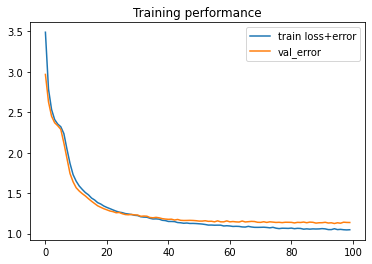

In [ ]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

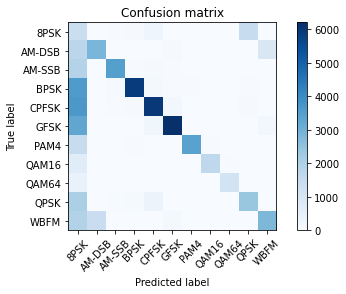

In [ ]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
predicted_classes1 = np.argmax(np.round(test_Y_hat), axis=1)
from sklearn.metrics import confusion_matrix
confnorm = confusion_matrix(testy, predicted_classes1)
plot_confusion_matrix(confnorm, labels=classes)

Overall Accuracy:  0.15135635018495686
Overall Accuracy:  0.1461609620721554
Overall Accuracy:  0.15674846625766872
Overall Accuracy:  0.16651133892513204
Overall Accuracy:  0.20169082125603865
Overall Accuracy:  0.2868193069306931
Overall Accuracy:  0.4602446483180428
Overall Accuracy:  0.5989404799002804
Overall Accuracy:  0.7137020741671904
Overall Accuracy:  0.8253141281029728
Overall Accuracy:  0.849306625577812
Overall Accuracy:  0.8744939271255061
Overall Accuracy:  0.8809815950920246
Overall Accuracy:  0.8956602031394275
Overall Accuracy:  0.8681860178626425
Overall Accuracy:  0.8930759803921569
Overall Accuracy:  0.8982477712880418
Overall Accuracy:  0.8554895214263372
Overall Accuracy:  0.8810259579728059
Overall Accuracy:  0.9070631970260223


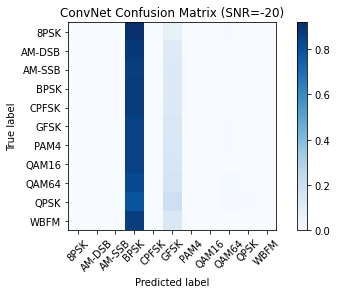

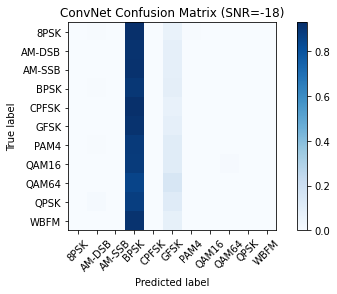

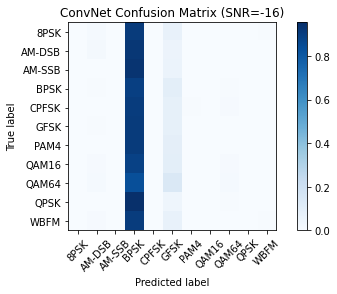

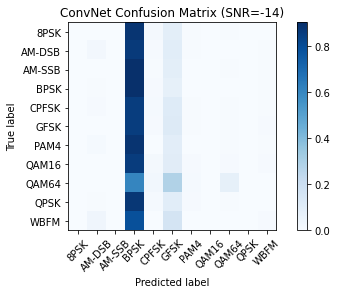

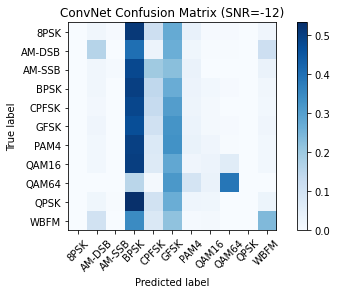

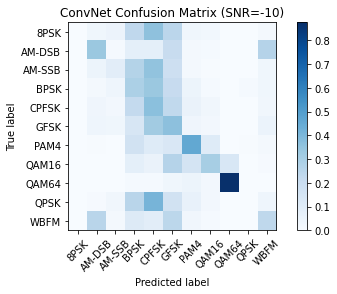

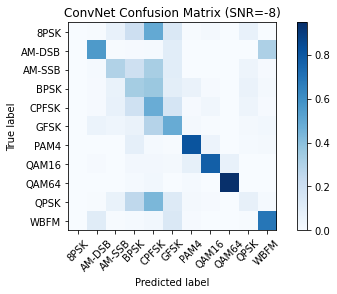

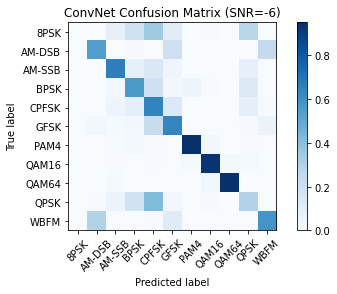

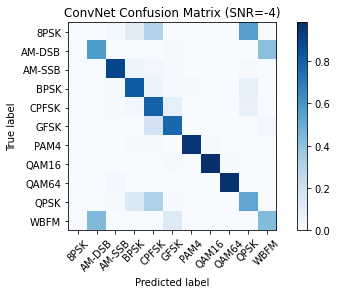

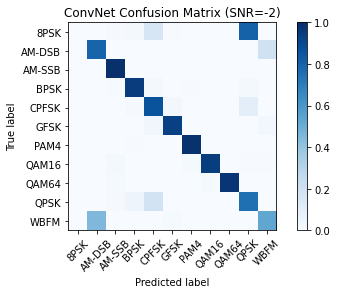

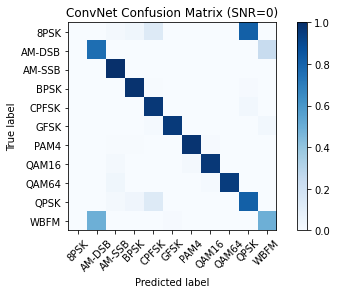

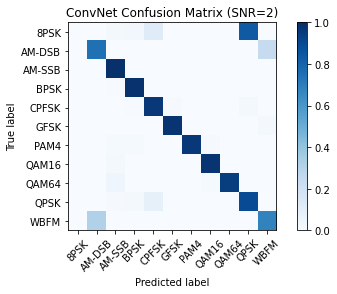

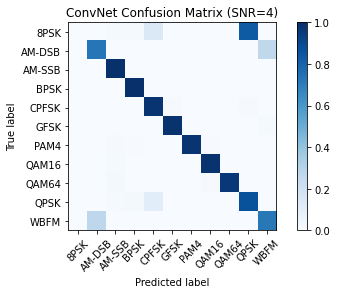

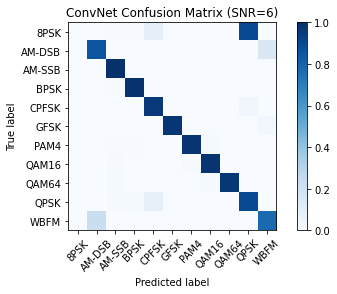

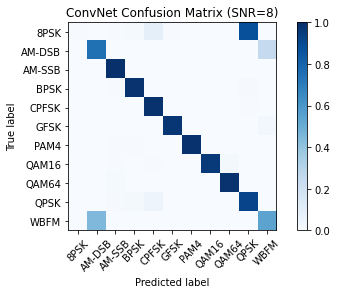

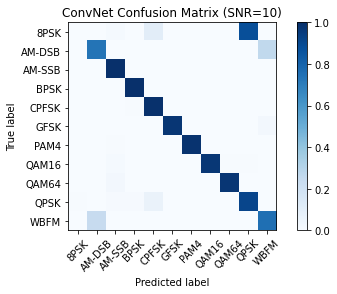

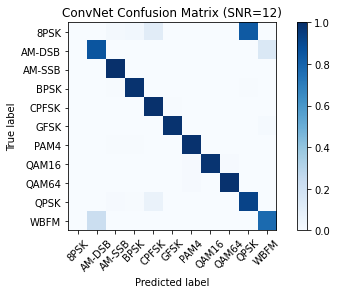

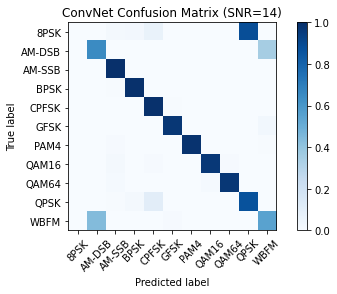

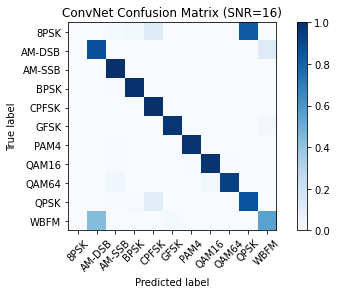

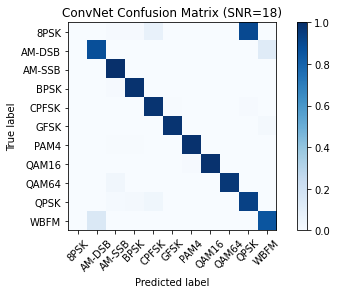

In [ ]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)

    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

In [ ]:
# Save results to a pickle file for plotting later
#print acc
fd = open('results_cnn2_d0.5.dat','wb')
pickle.dump( ("CNN2", 0.5, acc) , fd )

Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

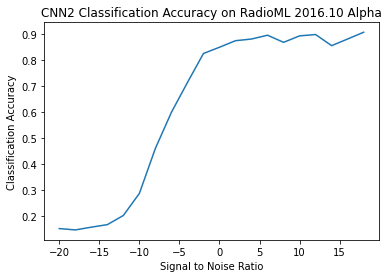

In [ ]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")